<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Ready

As usual, there are a few things we need to do before we can begin. We'll start by importing the packages we'll need.

In [1]:
import os

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

Next, let's also print out the version numbers for our libraries as well as the Python version. This makes our analysis reproducible for anyone who wants to review or reuse our work.

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("PIL version : ", PIL.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
torchinfo version :  1.8.0
numpy version :  1.26.3
matplotlib version :  3.9.2
PIL version :  10.2.0
Python 3.11.0


As we've done in past lessons, we'll also check if GPUs are available. Remember that some computers come with GPUs, which allow for bigger and faster model training. The `cuda` package is used to access GPUs on Linux and Windows machines in PyTorch; `mps` is used on Macs. 

We'll use the `device` variable later to set the location of our data and model.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Exploring and Preparing Our Data

We'll work with images of crop disease from Uganda which we prepared in the previous lesson. You may remember that we created an undersampled dataset that has a uniform distribution across classes. Let's use that dataset.

The data is in the `data_p2` folder within which is the `data_undersampled` folder. In that folder we have the `train` folder that contains the training data.

**Task 2.3.1:** Assign `train_dir` the path to the training data. Follow the pattern of `data_dir`.

In [4]:
data_dir = os.path.join("data_p2", "data_undersampled")
train_dir = os.path.join(data_dir, "train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

Data Directory: data_p2/data_undersampled
Training Data Directory: data_p2/data_undersampled/train


Next let's check what classes we have in the data. Images from each class are contained in a separate subdirectory in `train_dir` where the name of each subdirectory is the name of the class.

**Task 2.3.2:** Create a list of class names using `os.listdir`.

In [5]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['cassava-healthy', 'cassava-mosaic-disease-cmd', 'cassava-brown-streak-disease-cbsd', 'cassava-green-mottle-cgm', 'cassava-bacterial-blight-cbb']


Following what we did in the previous lesson to standardize the images, we'll again use the same set of transformations:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$)
- Convert the image to a Tensor of pixel values
- Normalize the data (we normalize each color channel separately)

Here's the custom transformation that we've used before which converts images to RGB format:

In [6]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

Now we'll use `transforms.Compose` from `torchvision` package to compose our pipeline of transformations.

**Task 2.3.3:** Complete the transformation pipeline below. It's missing the last two steps (converting images to PyTorch tensors and normalizing them). In the normalization step, make sure to use the `mean` and `std` values from the previous lesson.

In [7]:
# Define transformation to apply to the images
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        # Convert images to tensors
        transforms.ToTensor(),
        # Normalize the tensors (copy the mean and std from previous lesson!)
        transforms.Normalize(
            mean=[0.4326, 0.4953, 0.312], std= [0.2178, 0.2214, 0.2091]
        )
    ]
)

print(type(transform_normalized))
print("-----------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-----------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4326, 0.4953, 0.312], std=[0.2178, 0.2214, 0.2091])
)


We are now ready to create our dataset with our transformations.

**Task 2.3.4:** Make a normalized dataset using `ImageFolder` from `datasets` and print the length of the dataset.

In [8]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform_normalized )

print('Length of dataset:', len(dataset))

Length of dataset: 7615


### Train and validation splitting

We'll follow good practice and divide our data into two parts. One part will be the data we'll train our model on. The second part will be used to evaluate the model on images it hasn't seen in training.

This is an important step in order for us to check how good the model is. If it makes good predictions on the training data but not on the validation data, we'll know the model's overfit.

**Task 2.3.5:** Use `random_split` to create a 80/20 split (training dataset should have 80% of the data, validation dataset should have 20% of the data).

<div class="alert alert-info" role="alert">
    <p><b>About random number generators</b></p>
<p>The following cell adds a <code>generator=g</code> line of code that is not present in the video. This is something we have added to make sure you always get the same results in your predictions. Please don't change it or remove it.
</p>
</div>

In [9]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 6092
Length of validation dataset: 1523


Now let's make sure that the training data indeed contains 80% of the dataset and the validation set 20%.

**Task 2.3.6:** Compute the length of the entire dataset, the training dataset and the validation dataset. We've added the code that computes the percentage of data that's training data and percentage that's validation.

In [10]:
length_dataset = len(dataset)
length_train = len(train_dataset)
length_val = len(val_dataset)

percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


We're also curious about the breakdown of the classes. We're using the dataset that we prepared in such a way that all classes have the same number of images. But let's make sure that this is indeed true! 

We'll reuse the `class_count` function that we can import from `training.py`. The function goes through a dataset and counts how many images are in each class.

**Task 2.3.7:** Use `class_counts` function on the entire dataset and visualize the results with a bar chart. Note that computing `dataset_counts` may take a long time.

  0%|          | 0/6092 [00:00<?, ?it/s]

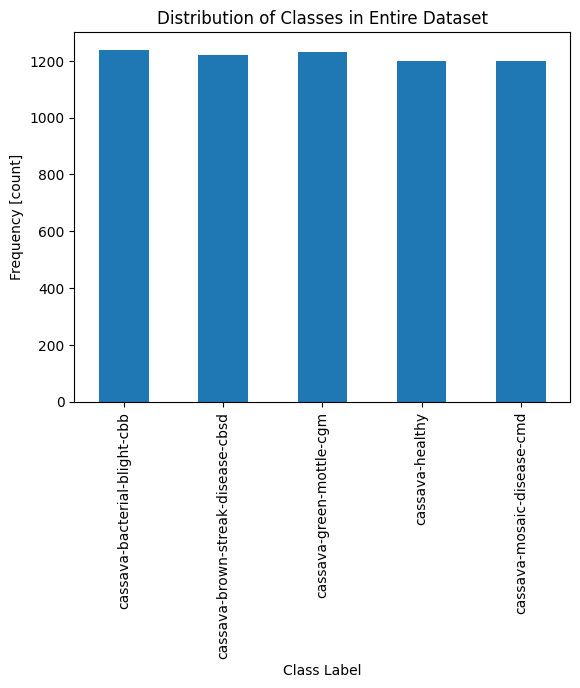

In [11]:
from training import class_counts

dataset_counts = class_counts(train_dataset)

# Make a bar chart from the function output
dataset_counts.plot(kind =  "bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Entire Dataset");

**Task 2.3.8:** Use the `class_counts` function and pandas plotting to make the same plot for the training data.

  0%|          | 0/6092 [00:00<?, ?it/s]

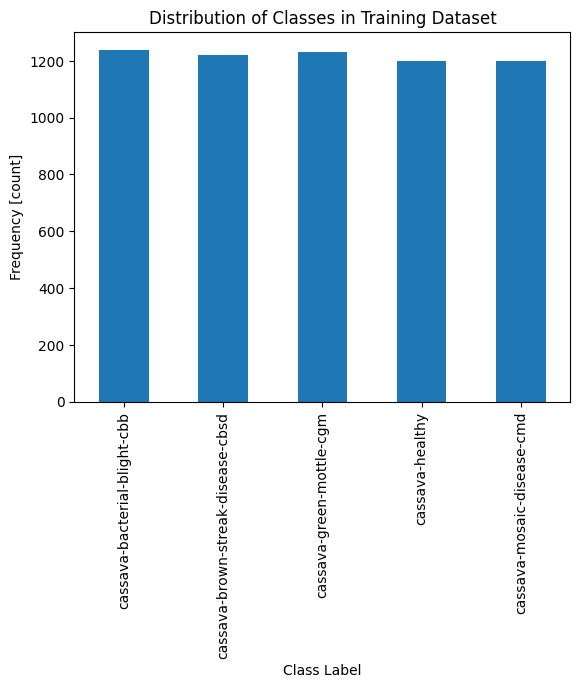

In [12]:
train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.plot(kind = "bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

Let's make the same plot, but this time for the validation data.

**Task 2.3.9:** Use the `class_counts` function and pandas plotting to get the breakdown across classes for the validation split.

  0%|          | 0/1523 [00:00<?, ?it/s]

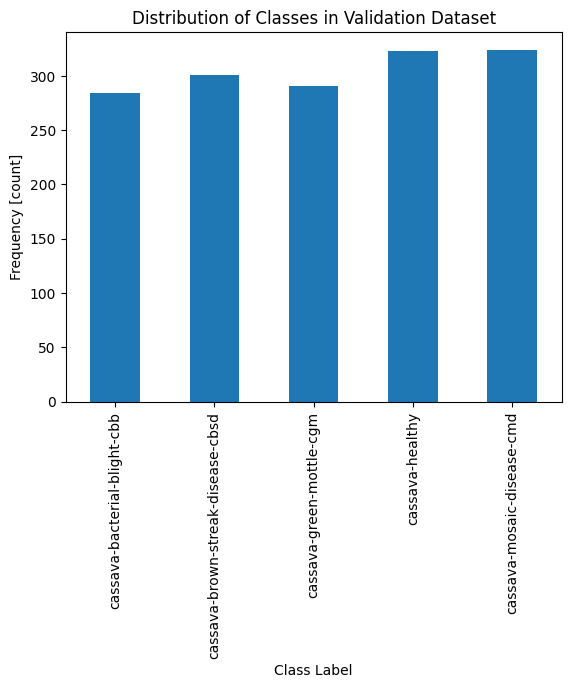

In [13]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.plot(kind = "bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

From these visualizations, we see that we indeed have a roughly uniform distribution across classes in the entire dataset as well as in the training and validation splits. Some deviations from a uniform distribution are normal given that we're working with a fairly small number of observations when it comes to statistics.

Well done! We're now ready to create `DataLoader` objects. We'll use a batch size of 32 and start with the `DataLoader` for training. Remember that in training we want to shuffle the data after each epoch.

<div class="alert alert-info" role="alert">
<p>Curious to learn more about data loaders (or any other class or function)? You can follow up the object name with a question mark as shown below. After running the code cell, the documentation for that object will be displayed for you.</p>

<p>Another way to bring up the documentation in Jupyter is to put your cursor at the end of object name and use shift+tab 🤓</p>
</div>

In [14]:
DataLoader?

Init signature:
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing


**Task 2.3.10:** Create the training loader. Make sure to set shuffling to be on.

In [15]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size , shuffle = True)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Next let's create a `DataLoader` for validation data.

**Task 2.3.11:** Create the validation loader. Make sure to set shuffling to be off.

In [16]:
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Next let's check the shape of a batch of images and labels. We'll use the `DataLoader` object and turn it into an iterator by using `iter`. Then with `next` we can fetch a batch of data.

We expect one batch of images to be a 4D tensor with dimension `[32, 3, 224, 224]` and one batch of labels to be a one dimensional tensor of length 32.

**Task 2.3.12:** Print the shape of a batch of images and the shape of a batch of labels.

In [17]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print("Shape of batch of images", image_shape)

label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


Out of curiosity, let's examine the `labels` tensor.

In [18]:
labels

tensor([2, 4, 0, 3, 4, 2, 4, 2, 2, 1, 2, 3, 0, 2, 1, 3, 1, 0, 4, 3, 0, 2, 4, 4,
        4, 2, 4, 1, 0, 1, 1, 4])

### Building a Convolutional Neural Network

As we learned in the previous project, a network architecture suitable for image classification is the convolutional neural network (CNN). It primarily consists of a sequence of convolutional and max pooling layers. These layers are followed by some fully connected layers and an output layer.

Let's build a CNN!

Same as previously, we'll use the `nn.Sequential` class from PyTorch to define the architecture. We'll start with an empty model and append layers to it one by one.

In [19]:
model = torch.nn.Sequential()

**Task 2.3.13:** Define the first convolutional layer of our network. Remember that we have three color channels, so set `in_channels=3`. Use $16$ kernels, each of size $3$ and set padding to $1$.

In [20]:
# Convolutional layer 1 (sees 3x224x224 image tensor)
conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
model.append(conv1)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


After the first convolutional layer, we'll use the ReLU activation and follow that with a max pooling layer.

In [21]:
max_pool1 = nn.MaxPool2d(2, 2)
model.append(torch.nn.ReLU())
model.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

**Task 2.3.14:** Define another convolutional layer of our network. This one should have $32$ kernels. Use kernels of size $3$ and padding of $1$.

In [22]:
# Convolutional layer 2 (sees 16x112x112 tensor)
conv2 = nn.Conv2d(16, 32, 3, padding = 1)
max_pool2 = nn.MaxPool2d(2, 2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


**Task 2.3.15:** Define the last convolutional layer of our network. This one should have $64$ kernels. Again use kernels of size $3$ and padding of $1$.

In [23]:
# Convolutional layer 3 (sees 32x56x56 tensor)
conv3 = nn.Conv2d(32, 64, 3, padding = 1)
max_pool3 = nn.MaxPool2d(2, 2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


Next we'll add the flattening layer and a `Dropout` layer.

In [24]:
model.append(torch.nn.Flatten())
model.append(nn.Dropout(0.5))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
)

While we could go straight to our output $5$ classes from here, we'll get better performance by adding another layer. We're getting 64 * 28 * 28 outputs from the flattening layer, let's feed that into a dense layer.

**Task 2.3.16:** Add a `Linear` layer to the model. You'll need to tell it the size of the input, and how many neurons we want in the layer (let's use $500$ neurons).

In [25]:
# Linear layer (64 * 28 * 28 -> 500)
linear1 = torch.nn.Linear(64 * 28 * 28 , 500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
)


We are ready to add the final layer to the model. It should have as many neurons as we have classes.

**Task 2.3.17:** Add the output layer to the model. 

In [26]:
# Linear layer (500 -> 5)
output_layer = nn.Linear(500, 5)
model.append(output_layer)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)


We have our model! Let's train it!

### Training the Model

Let's define the loss and what optimizer we'll use. We'll go with the standard loss function in classification problems, cross entropy. For the optimizer we'll chose Adam optimizer as we've done before.

**Task 2.3.18:** Define cross-entropy as the loss function and set Adam optimizer to be the optimizer. You can use the default learning rate `lr=0.001`.

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Let's use the GPU we have at our disposal and place our model on `device`. We'll also print the summary of the model.

In [28]:
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

In [29]:
height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

Notice the huge number of parameters that this model has! Are you starting to worry about overfitting? Although neural networks tend to overfit less than other models, we can still overfit with them. We can actually show that using this model. Let's train it for many epochs and demonstrate overfitting.

For training the model, we can import the functions we built in the last project. Same as before, we have a `training.py` file here, which contains the `train` function. Note that the `train` function has been slightly modified - it now returns the losses and accuracies. Otherwise it's the same as in Project 1. The cell below prints out the arguments it needs.

In [30]:
from training import train

In [31]:
train?

Signature:
train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    use_train_accuracy=True,
)
Docstring: <no docstring>
File:      /app/training.py
Type:      function

**Task 2.3.19:** Use the `train` function to train the model for 15 epochs. Note that this may take a long time to run.

<div class="alert alert-info" role="alert"> <strong>Regarding Model Training Times</strong>

This task involves training a neural network for <b>15 epochs</b>. As highlighted in the accompanying video, the training process is computationally intensive and can be very time-consuming. On most systems, each epoch may take between 10 and 15 minutes, meaning the entire training process could last well over one hour. In an online lab, this could result in timeouts or interruptions.
<br>

To streamline your learning experience, where the video omits over an hour of training footage, we have provided a pre-trained model for your convenience. This model is an exact replica of the one you have been working on, trained for 15 epochs and carefully serialized using <code>torch.save()</code>.

Upon completing the video for this task you can proceed by loading the pre-trained model indicated in the cell after the empty <code>train(...)</code> one.

<b>We strongly recommend you to use the saved model instead of training your own for 15 epochs</b>
</div>

In [33]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model, optimizer, loss_fn, train_loader, val_loader, epochs = 15, device = device
)

Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.46
    Training accuracy: 0.34
    Validation loss: 1.46
    Validation accuracy: 0.32


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.35
    Training accuracy: 0.42
    Validation loss: 1.38
    Validation accuracy: 0.38


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.26
    Training accuracy: 0.45
    Validation loss: 1.34
    Validation accuracy: 0.40


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.11
    Training accuracy: 0.56
    Validation loss: 1.33
    Validation accuracy: 0.44


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.99
    Training accuracy: 0.63
    Validation loss: 1.33
    Validation accuracy: 0.43


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.75
    Training accuracy: 0.74
    Validation loss: 1.38
    Validation accuracy: 0.43


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.41
    Training accuracy: 0.90
    Validation loss: 1.50
    Validation accuracy: 0.43


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.21
    Training accuracy: 0.96
    Validation loss: 1.68
    Validation accuracy: 0.43


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.15
    Training accuracy: 0.98
    Validation loss: 1.65
    Validation accuracy: 0.44


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.06
    Training accuracy: 0.99
    Validation loss: 1.94
    Validation accuracy: 0.44


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 11
    Training loss: 0.05
    Training accuracy: 0.99
    Validation loss: 1.94
    Validation accuracy: 0.43


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 12
    Training loss: 0.04
    Training accuracy: 0.99
    Validation loss: 2.34
    Validation accuracy: 0.42


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 13
    Training loss: 0.02
    Training accuracy: 0.99
    Validation loss: 2.30
    Validation accuracy: 0.44


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 14
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 2.04
    Validation accuracy: 0.46


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 15
    Training loss: 0.02
    Training accuracy: 0.99
    Validation loss: 2.23
    Validation accuracy: 0.46


**[RECOMMENDED]** Load the pre-trained model:

In [34]:
model = torch.load("model_trained.pth", weights_only=False)
model.to("cuda")

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

Now let's plot the learning curve, so training and validation loss as a function of epoch number. And let's add a similar plot for training and validation accuracy.

<div class="alert alert-info" role="alert"> <strong>Loading Evaluation Metrics</strong>

The next cell plots the training and validation losses and accuracies resulting from training the model for 15 epochs. Since we're recommending you to train the model for fewer epochs and instead loading the pretrained model, you'll also need to load the metrics that we have saved along with the model.

To do so, execute the following cell that loads the CSV with the values of these metrics that we have saved after our training. Feel free to explore the dataframe freely.
</div>

In [38]:
df = pd.read_csv('post_train_evaluation_metrics.csv')

In [39]:
train_losses = df['Train Loss']
valid_losses = df['Validation Loss']

train_accuracies = df['Train Accuracy']
valid_accuracies = df['Validation Accuracy']

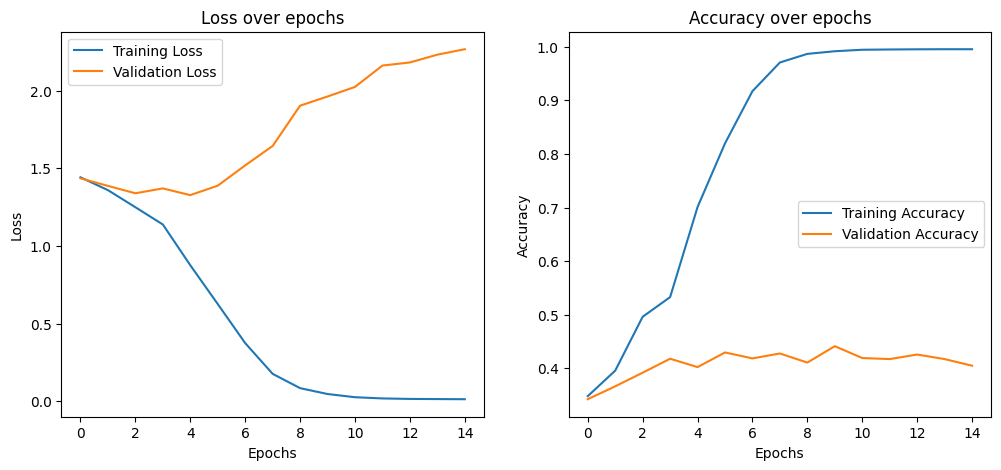

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

This training loop results show a common pattern observed in deep learning models: As training progresses, the training accuracy improves significantly, suggesting that the model's effectively learning from the training dataset. However, the validation accuracy does not improve at the same rate, and the validation loss starts to increase after a certain point. This is a classic sign of overfitting.

<div class="alert alert-info" role="alert">
<p>Oh no, we&rsquo;re overfitting! 🤯</p>

<p>Overfitting occurs when a model learns the training data too well, capturing noise and details to the extent that it negatively impacts the model&rsquo;s performance on new data. The symptoms of overfitting in our training results are:</p>

<ul>
<li>High training accuracy: The model performs exceptionally well on the training data.</li>
<li>Increasing validation loss: Despite improvements in training loss and accuracy, the validation loss starts to increase after reaching a certain point.</li>
<li>Stagnant or decreasing validation accuracy: The model&rsquo;s ability to generalize to unseen data does not improve or worsens as training progresses.</li>
</ul>


<p><strong>Addressing Overfitting</strong></p>

<p>To mitigate overfitting, consider the following strategies:</p>

<ul>
<li><p><strong>Data Augmentation</strong>: Augment the training data by applying random transformations (e.g., rotations, scaling, flips) to generate new training samples. This can help the model generalize better.</p></li>
<li><p><strong>Dropout</strong>: Introduce dropout layers into our network. Dropout randomly sets a fraction of input units to 0 during training, which helps prevent the model from becoming too reliant on any single feature.</p></li>
<li><p><strong>Regularization</strong>: Apply regularization techniques, such as L1 or L2 regularization, which add a penalty on the magnitude of network parameters. This can discourage complex models that overfit.</p></li>
<li><p><strong>Early Stopping</strong>: Monitor the model&rsquo;s performance on a validation set and stop training when the validation loss starts to increase, which is a sign that the model's beginning to overfit.</p></li>
<li><p><strong>Reduce Model Complexity</strong>: Simplify your model by reducing the number of layers or the number of units in the layers. A simpler model may generalize better.</p></li>
<li><p><strong>Use More Data</strong>: If possible, adding more data can help the model learn better and generalize well to new, unseen data.</p></li>
<li><p><strong>Batch Normalization</strong>: Although primarily used to help with training stability and convergence, batch normalization can sometimes also help with overfitting by regularizing the model somewhat.</p></li>
<li><p><strong>Cross-validation</strong>: Helps prevent overfitting by testing the model on different parts of the data, ensuring it performs well on new data.</p></li>
</ul>
</div>

We'll use some of these strategies in the following lessons.

Let's conclude this lesson by computing the confusion matrix for our model using the validation data. You may remember that in order to obtain the confusion matrix, we need the predictions of the model and the target values.

We'll obtain the probabilities that our model predicts by using the `predict` function from `training.py`. This function expects the model, the loader and the device as input arguments.

**Task 2.3.20:** Use the `predict` function from `training.py` to compute probabilities that our model predicts on the validation data. The rest of the code provided will take these probabilities and compute the predicted classes.

<div class="alert alert-info" role="alert"> <strong>Use the pre-trained model</strong>

For the following activity, we have assumed that you're using the pre-trained model from activity <code>2.3.19</code>. If you have trained the model by yourself, the activity <code>2.3.20</code> will not evaluate correctly.

Make sure you're loading the model from the pre-trained data as specified above.
</div>

In [41]:
from training import predict

probabilities_val = probabilities = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/48 [00:00<?, ?it/s]

tensor([0, 4, 4,  ..., 1, 0, 0], device='cuda:0')


All we need before we can compute the confusion matrix is the target values, so let's compute those.

In [42]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(val_loader, desc="Get Labels")]
).to(device)

Get Labels: 100%|██████████| 48/48 [00:10<00:00,  4.77it/s]


Now we can get the confusion matrix.

<Figure size 1000x800 with 0 Axes>

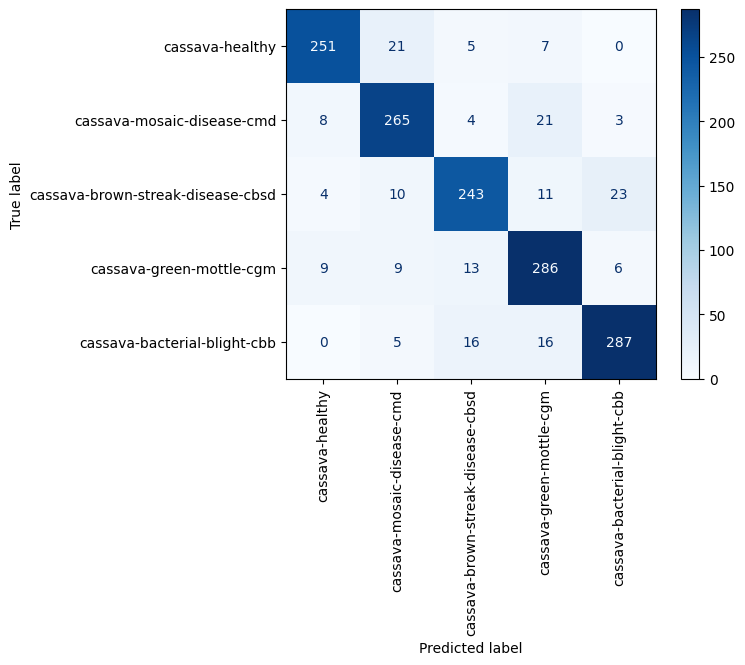

In [43]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

The confusion matrix looks like quite a mess, which we expect, since the model's so overfit.

### Conclusion

In this lesson, we worked hard to create a CNN model, trained the model for a long time, and what we ended up with was a model that overfits! 😫

But along the way, we practiced and learned some important things:
- Once more we preprocessed our data to make it ready for deep learning. 
- We built a CNN with 3 convolutional and max pooling layers, followed by flattening and two dense layers.
- We used `nn.Sequential` to easily build our model's architecture by defining the order of the layers.
- Training the model for too many epochs produced an overfit model.
- We discussed techniques to combat overfitting, which we'll see in future lessons.


In the next lesson we'll learn that we don't have to build and train our neural network from scratch. That sounds promising!

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).